Loading 8 files...

--- Client Data Allocation ---
Client 0: 15093 Train samples, 1677 Val samples
Client 1: 2720 Train samples, 303 Val samples
Client 2: 36452 Train samples, 4051 Val samples
Client 3: 42997 Train samples, 4778 Val samples
Client 4: 19016 Train samples, 2113 Val samples

Starting Privacy-Preserving Heterogeneous FL...

--- Round 1 Statistics ---
Client 0: [Train] Acc 0.9857 | [Val] Acc 0.9845
Client 1: [Train] Acc 0.9353 | [Val] Acc 0.9142
Client 2: [Train] Acc 0.9791 | [Val] Acc 0.9822
Client 3: [Train] Acc 0.9803 | [Val] Acc 0.9791
Client 4: [Train] Acc 0.9546 | [Val] Acc 0.9527

--- Round 2 Statistics ---
Client 0: [Train] Acc 0.9880 | [Val] Acc 0.9857
Client 1: [Train] Acc 0.9577 | [Val] Acc 0.9373
Client 2: [Train] Acc 0.9809 | [Val] Acc 0.9835
Client 3: [Train] Acc 0.9853 | [Val] Acc 0.9847
Client 4: [Train] Acc 0.9097 | [Val] Acc 0.9025

--- Round 3 Statistics ---
Client 0: [Train] Acc 0.9882 | [Val] Acc 0.9887
Client 1: [Train] Acc 0.9643 | [Val] Acc 0.9505
Cl

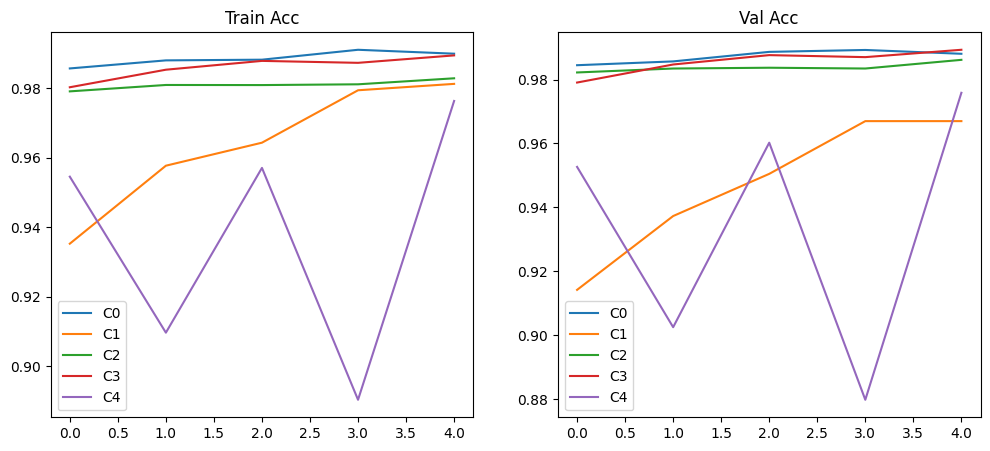

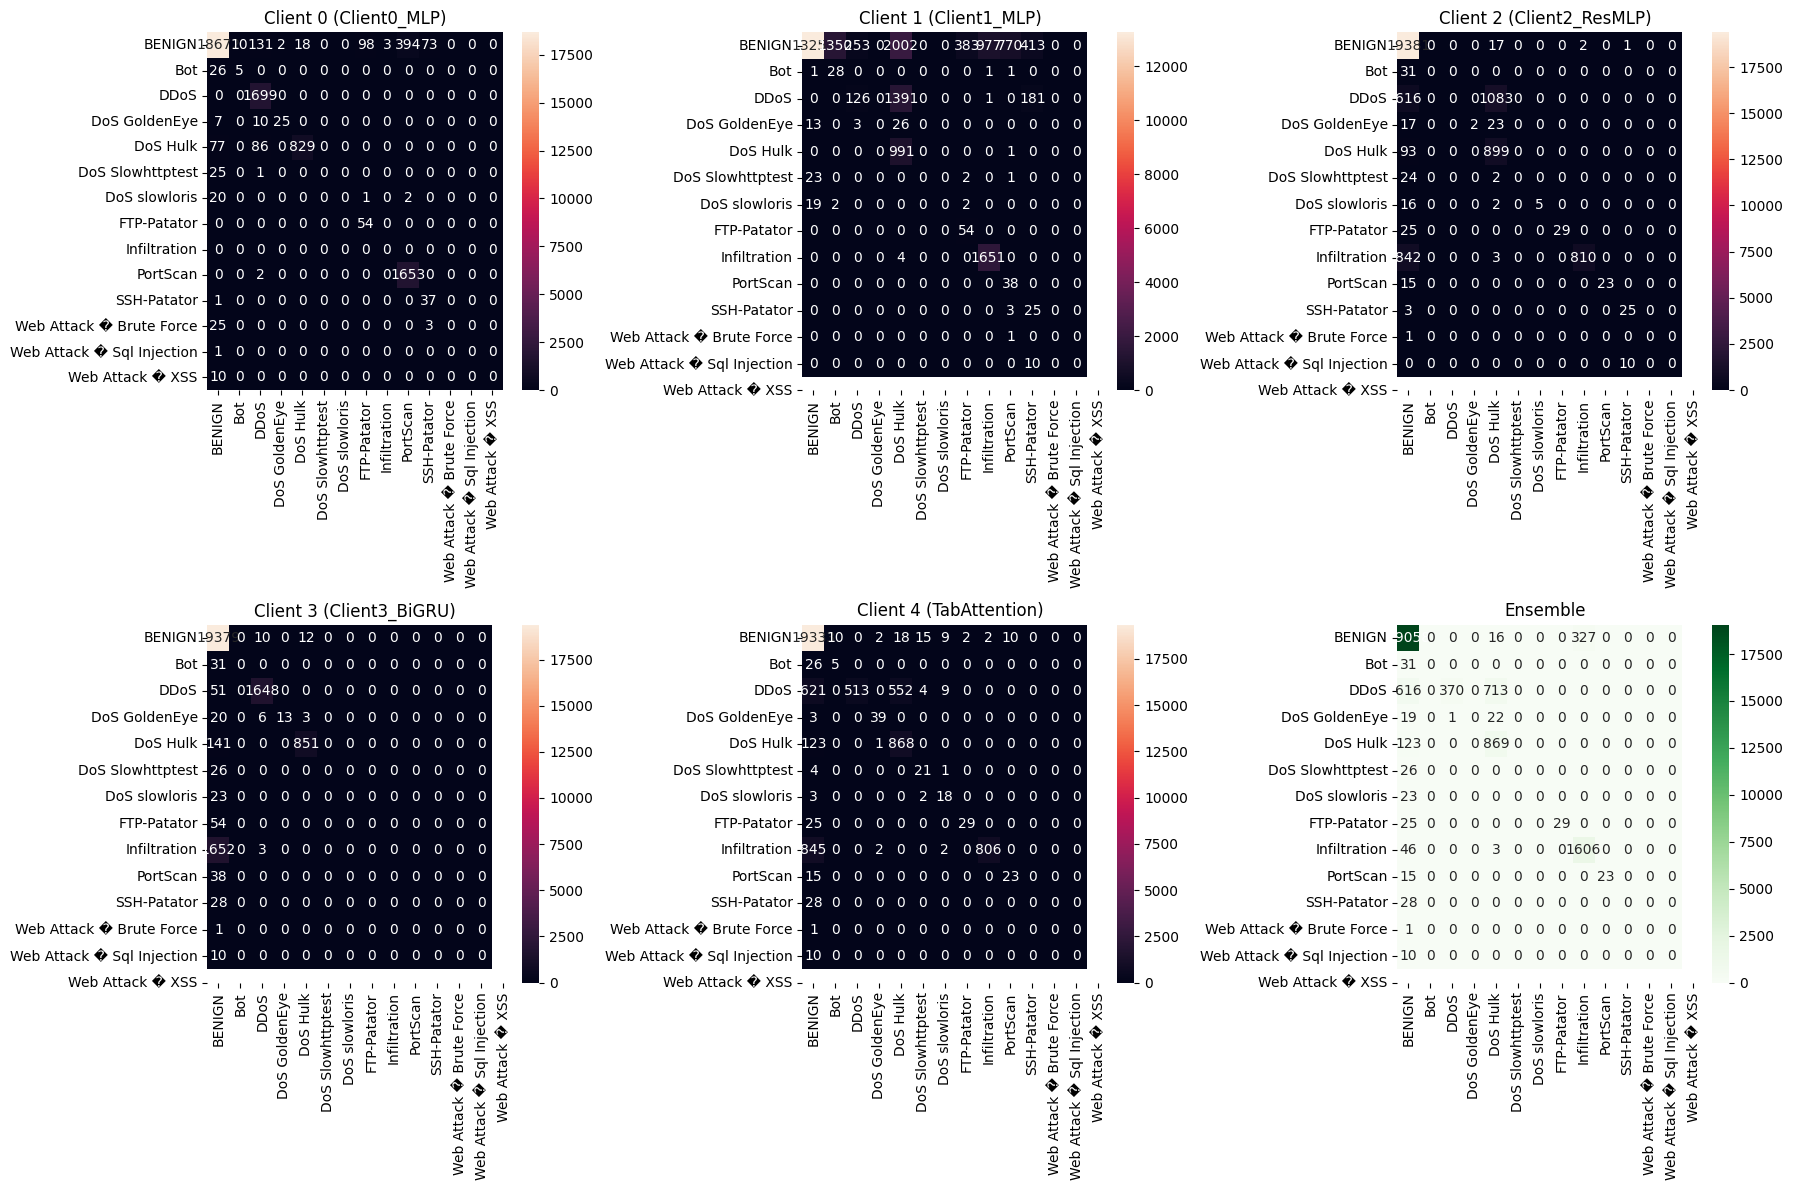


Final Global Ensemble Accuracy: 0.9148


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tenseal as ts
import gc

SEED = 42
BATCH_SIZE = 128
NUM_CLIENTS = 5
PUBLIC_DATA_RATIO = 0.05 
VAL_SIZE = 0.1
ROUNDS = 5
LOCAL_EPOCHS = 3 

torch.manual_seed(SEED)
np.random.seed(SEED)

# DATA PREPARATION

DATASET_DIR = r"C:\Users\SREENITHI\PrivacyPreservingFederatedLearning_IDS _HE\data"
csv_files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))

mini_batches = []
SAMPLES_PER_FILE = 20000 

print(f"Loading {len(csv_files)} files...")
for f in csv_files:
    try:
        df_chunk = pd.read_csv(f)
        df_chunk.columns = df_chunk.columns.str.strip()
        df_chunk = df_chunk.replace([np.inf, -np.inf], np.nan).dropna()
        if len(df_chunk) > SAMPLES_PER_FILE:
            df_chunk = df_chunk.sample(n=SAMPLES_PER_FILE, random_state=SEED)
        mini_batches.append(df_chunk)
        del df_chunk 
        gc.collect()
    except Exception as e:
        print(f"Skipping {f}: {e}")

data = pd.concat(mini_batches, ignore_index=True)
y_raw = data["Label"].values
X_df = data.drop(columns=["Label"]).apply(pd.to_numeric, errors="coerce").fillna(0)
X_raw = np.clip(X_df.to_numpy(), -1e6, 1e6)

le = LabelEncoder()
y_all = le.fit_transform(y_raw)
OUTPUT_DIM = len(le.classes_)
INPUT_DIM = X_raw.shape[1]

X_train_full, X_test_global, y_train_full, y_test_global = train_test_split(
    X_raw, y_all, test_size=0.15, stratify=y_all, random_state=SEED
)

scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_global = scaler.transform(X_test_global) 

X_train_private, X_public, y_train_private, y_public = train_test_split(
    X_train_full, y_train_full, test_size=PUBLIC_DATA_RATIO, stratify=y_train_full, random_state=SEED
)
X_public_tensor = torch.tensor(X_public, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_global, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_global, dtype=torch.long)

# NON-IID DATA SPLIT (DIRICHLET)

def prepare_clients(X, y, num_clients=5, alpha=0.5):
    idx_by_label = {lbl: np.where(y == lbl)[0] for lbl in np.unique(y)}
    client_indices = {i: [] for i in range(num_clients)}
    for lbl, idxs in idx_by_label.items():
        np.random.shuffle(idxs)
        proportions = (np.random.dirichlet([alpha] * num_clients) * len(idxs)).astype(int)
        while proportions.sum() < len(idxs): proportions[np.argmax(proportions)] += 1
        start = 0
        for cid, cnt in enumerate(proportions):
            client_indices[cid].extend(idxs[start:start + cnt])
            start += cnt
    clients_data = []
    print("\n--- Client Data Allocation ---")
    for cid in range(num_clients):
        idxs = client_indices[cid]
        tr_idx, val_idx = train_test_split(idxs, test_size=VAL_SIZE, random_state=SEED)
        clients_data.append({
            'train': (torch.tensor(X[tr_idx], dtype=torch.float32), torch.tensor(y[tr_idx], dtype=torch.long)),
            'val': (torch.tensor(X[val_idx], dtype=torch.float32), torch.tensor(y[val_idx], dtype=torch.long)),
            'n_samples': len(tr_idx)
        })
        print(f"Client {cid}: {len(tr_idx)} Train samples, {len(val_idx)} Val samples")
    return clients_data

clients = prepare_clients(X_train_private, y_train_private, num_clients=NUM_CLIENTS)
TOTAL_TRAIN_SAMPLES = sum(c['n_samples'] for c in clients)

# MODELS & ENCRYPTION

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.generate_galois_keys()
context.global_scale = 2**40

class Client0_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 512), nn.ReLU(), nn.Linear(512, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client1_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 256), nn.ReLU(), nn.Linear(256, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client2_ResMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1, self.fc2 = nn.Linear(INPUT_DIM, 256), nn.Linear(256, OUTPUT_DIM)
    def forward(self, x): return self.fc2(F.relu(self.fc1(x)))

class Client3_BiGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, OUTPUT_DIM)
    def forward(self, x):
        _, h = self.gru(x.unsqueeze(-1))
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))

class TabAttention(nn.Module):
    def __init__(self, input_dim, output_dim, n_heads=4, embed_dim=32):
        super().__init__()
        # Map each feature to an embedding space
        self.feature_embed = nn.Linear(1, embed_dim)
        # Multi-head Self Attention
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, batch_first=True)
        # Layer Norm and Feed-Forward
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim * embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x shape: [batch, input_dim] -> [batch, input_dim, 1]
        x = x.unsqueeze(-1)
        # Embedding: [batch, input_dim, embed_dim]
        x = self.feature_embed(x)
        # Attention
        attn_out, _ = self.attention(x, x, x)
        x = self.ln(x + attn_out)
        # Flatten and Classify
        x = x.view(x.size(0), -1)
        return self.fc(x)

models = {
    0: Client0_MLP(), 
    1: Client1_MLP(), 
    2: Client2_ResMLP(), 
    3: Client3_BiGRU(), 
    4: TabAttention(INPUT_DIM, OUTPUT_DIM)
}
optimizers = {cid: optim.Adam(models[cid].parameters(), lr=1e-3) for cid in range(NUM_CLIENTS)}

# HELPERS, LOOP & PLOTTING (Same as original)

history_val = {cid: [] for cid in range(NUM_CLIENTS)}
history_train = {cid: [] for cid in range(NUM_CLIENTS)}

def get_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
    return accuracy_score(y_true, preds), f1_score(y_true, preds, average="weighted")

def local_train_and_encrypt(cid):
    model, opt = models[cid], optimizers[cid]
    Xc, yc = clients[cid]['train']
    model.train()
    for epoch in range(LOCAL_EPOCHS):
        for i in range(0, len(Xc), BATCH_SIZE):
            opt.zero_grad()
            loss = F.cross_entropy(model(Xc[i:i+BATCH_SIZE]), yc[i:i+BATCH_SIZE])
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        avg_logits = model(X_public_tensor).mean(dim=0).cpu().numpy()
    weight = clients[cid]['n_samples'] / TOTAL_TRAIN_SAMPLES
    return ts.ckks_vector(context, avg_logits * weight)

def server_aggregate(encrypted_list):
    agg = encrypted_list[0]
    for i in range(1, len(encrypted_list)): agg += encrypted_list[i]
    return agg

def client_decryption_and_distill(cid, encrypted_global_vec):
    global_logits_plaintext = encrypted_global_vec.decrypt() 
    target = torch.tensor(global_logits_plaintext, dtype=torch.float32)
    model, opt = models[cid], optimizers[cid]
    model.train()
    opt.zero_grad()
    loss = F.mse_loss(model(X_public_tensor).mean(dim=0), target)
    loss.backward()
    opt.step()

print("\nStarting Privacy-Preserving Heterogeneous FL...")

for r in range(ROUNDS):
    ciphertexts = [local_train_and_encrypt(cid) for cid in range(NUM_CLIENTS)]
    encrypted_global = server_aggregate(ciphertexts)
    for cid in range(NUM_CLIENTS):
        client_decryption_and_distill(cid, encrypted_global)

    print(f"\n--- Round {r+1} Statistics ---")
    for cid in range(NUM_CLIENTS):
        t_acc, t_f1 = get_metrics(models[cid], clients[cid]['train'][0], clients[cid]['train'][1])
        v_acc, v_f1 = get_metrics(models[cid], clients[cid]['val'][0], clients[cid]['val'][1])
        history_train[cid].append(t_acc)
        history_val[cid].append(v_acc)
        print(f"Client {cid}: [Train] Acc {t_acc:.4f} | [Val] Acc {v_acc:.4f}")

# Plotting & Confusion Matrix
def ensemble_predict(models_dict, X):
    outputs = [models_dict[cid](X) for cid in models_dict]
    return torch.argmax(torch.stack(outputs).mean(dim=0), dim=1).cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); [plt.plot(history_train[i], label=f'C{i}') for i in range(5)]; plt.title('Train Acc'); plt.legend()
plt.subplot(1, 2, 2); [plt.plot(history_val[i], label=f'C{i}') for i in range(5)]; plt.title('Val Acc'); plt.legend()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for cid in range(NUM_CLIENTS):
    y_pred = torch.argmax(models[cid](X_test_tensor), dim=1).cpu().numpy()
    sns.heatmap(confusion_matrix(y_test_global, y_pred), annot=True, fmt='d', ax=axes[cid], xticklabels=le.classes_, yticklabels=le.classes_)
    axes[cid].set_title(f'Client {cid} ({models[cid].__class__.__name__})')

y_pred_ens = ensemble_predict(models, X_test_tensor)
sns.heatmap(confusion_matrix(y_test_global, y_pred_ens), annot=True, fmt='d', cmap='Greens', ax=axes[5], xticklabels=le.classes_, yticklabels=le.classes_)
axes[5].set_title('Ensemble')
plt.tight_layout()
plt.show()

print(f"\nFinal Global Ensemble Accuracy: {accuracy_score(y_test_global, y_pred_ens):.4f}")

In [3]:
print("\n--- Client-wise Class Distribution ---")
for cid in range(NUM_CLIENTS):
    y_client = clients[cid]['train'][1].cpu().numpy()
    unique, counts = np.unique(y_client, return_counts=True)
    dist = dict(zip(le.inverse_transform(unique), counts))
    print(f"Client {cid}: {dist}")



--- Client-wise Class Distribution ---
Client 0: {'BENIGN': 3809, 'Bot': 11, 'DDoS': 5542, 'DoS GoldenEye': 6, 'DoS Hulk': 46, 'FTP-Patator': 124, 'Infiltration': 2, 'PortScan': 5508, 'SSH-Patator': 42, 'Web Attack � Brute Force': 2, 'Web Attack � Sql Injection': 1}
Client 1: {'BENIGN': 74, 'Bot': 86, 'DDoS': 11, 'DoS Hulk': 852, 'DoS Slowhttptest': 1, 'FTP-Patator': 77, 'PortScan': 1488, 'SSH-Patator': 71, 'Web Attack � Brute Force': 56, 'Web Attack � XSS': 4}
Client 2: {'BENIGN': 32861, 'Bot': 3, 'DoS GoldenEye': 1, 'DoS Hulk': 3058, 'DoS slowloris': 1, 'FTP-Patator': 44, 'PortScan': 353, 'SSH-Patator': 39, 'Web Attack � Brute Force': 55, 'Web Attack � XSS': 37}
Client 3: {'BENIGN': 39592, 'Bot': 26, 'DDoS': 2620, 'DoS GoldenEye': 17, 'DoS Hulk': 505, 'DoS Slowhttptest': 17, 'DoS slowloris': 21, 'PortScan': 175, 'SSH-Patator': 22, 'Web Attack � XSS': 2}
Client 4: {'BENIGN': 17661, 'Bot': 23, 'DDoS': 27, 'DoS GoldenEye': 180, 'DoS Hulk': 362, 'DoS Slowhttptest': 108, 'DoS slowloris':

In [4]:
print("\n--- Final Client-wise Performance ---")
for cid in range(NUM_CLIENTS):
    acc, f1 = get_metrics(models[cid], X_test_tensor, y_test_tensor)
    print(f"Client {cid} ({models[cid].__class__.__name__}): "
          f"Test Acc = {acc:.4f}, Test F1 = {f1:.4f}")



--- Final Client-wise Performance ---
Client 0 (Client0_MLP): Test Acc = 0.9573, Test F1 = 0.9575
Client 1 (Client1_MLP): Test Acc = 0.6736, Test F1 = 0.7327
Client 2 (Client2_ResMLP): Test Acc = 0.8822, Test F1 = 0.8484
Client 3 (Client3_BiGRU): Test Acc = 0.9121, Test F1 = 0.8749
Client 4 (TabAttention): Test Acc = 0.9023, Test F1 = 0.8861


In [5]:
ens_acc = accuracy_score(y_test_global, y_pred_ens)
ens_f1 = f1_score(y_test_global, y_pred_ens, average="weighted")

print("\n--- Global Ensemble Performance ---")
print(f"Ensemble Accuracy: {ens_acc:.4f}")
print(f"Ensemble F1-score: {ens_f1:.4f}")



--- Global Ensemble Performance ---
Ensemble Accuracy: 0.9148
Ensemble F1-score: 0.8989


In [8]:
sample_cipher = local_train_and_encrypt(0)
print("\n--- Encrypted Logits Info ---")
print("Ciphertext type:", type(sample_cipher))




--- Encrypted Logits Info ---
Ciphertext type: <class 'tenseal.tensors.ckksvector.CKKSVector'>
